# CREDIT CARD FRAUD DETECTION PROJECT
## Introduction
 Our research question for the following dataset is the following:

 **How does a unbalanced dataset (99.828% Class 1 (not fraud) | 0.172% Class 2 (fraud)) affect different machine learning and classificiation models in comparison to a artificially balanced dataset?**

 During this project we do the following;
<ol>
    <li><b>Visualize the Dataset</b> <ul>
        <li>Amount feature</li>
        <li>Time feature</li>
    </ul></li>
    <li><b>Visualize and understand significant features</b></li>
    <li><b>Build baseline model</b></li>
    <li><b>Perform preproccessing</b>
        <ul>
            <li>Rescaling</li>
            <li>Upsample and evaluate upsampling/downsampling methods</li>
        </ul>
    </li>
    <li><b>Build multiple models </b>
        <ul>
            <li>Naive bayesian</li>
            <li>K-Nearest-Neigbours</li>
            <li>Neural network</li>
        </ul>
    </li>
    <li><b>Evaluate models</b>
        <ul>
            <li>Confusion Matrix</li>
            <li>Classification Report</li>
        </ul>
    </li>
    <li>
        <b>Conclusion</b>
    </li>
</ol>

## Group contribution
During this project, we had open disscussion about all of the parts involved. Therefore all members contributed to nearly all topics each, at least in minor ways, such as perspectives or decision voting. Despite this, each member specialized in some topic;
<ul>
    <li>
    <b>Andreas | SMOTE, Neural Network</b>
    </li>
    <li>
    <b>Erlend | KNN</b>
    </li>
    <li>
    <b>Benjamin | Preprocessing, Naive Bayes and Model evaluation</b>
    </li>
    <li>
    <b>Evan | Visualization, markdown </b>
    </li>
    <li>
    <b> Mosagwe | Correlations and Significant features. </b>
    </li>
</ul>

### Basic imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,plot_roc_curve,accuracy_score,recall_score
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE


2022-11-18 22:32:41.098717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-18 22:32:41.227679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-18 22:32:41.227699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-18 22:32:41.251082: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 22:32:41.801572: W tensorflow/stream_executor/platform/de

Load in the creditcard csv data using pandas.

In [3]:
warnings.filterwarnings('ignore')
cd_df = pd.read_csv("creditcard.csv")
rnd_state = 69

Printing the header and first few rows to get a look at the data. Also printing the shape and info

Retrieve key statistical information about the data.

In [4]:
cd_df.describe().round(2).style.background_gradient()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.860000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.350000,0.000000
std,47488.150000,1.960000,1.650000,1.520000,1.420000,1.380000,1.330000,1.240000,1.190000,1.100000,1.090000,1.020000,1.000000,1.000000,0.960000,0.920000,0.880000,0.850000,0.840000,0.810000,0.770000,0.730000,0.730000,0.620000,0.610000,0.520000,0.480000,0.400000,0.330000,250.120000,0.040000
min,0.000000,-56.410000,-72.720000,-48.330000,-5.680000,-113.740000,-26.160000,-43.560000,-73.220000,-13.430000,-24.590000,-4.800000,-18.680000,-5.790000,-19.210000,-4.500000,-14.130000,-25.160000,-9.500000,-7.210000,-54.500000,-34.830000,-10.930000,-44.810000,-2.840000,-10.300000,-2.600000,-22.570000,-15.430000,0.000000,0.000000
25%,54201.500000,-0.920000,-0.600000,-0.890000,-0.850000,-0.690000,-0.770000,-0.550000,-0.210000,-0.640000,-0.540000,-0.760000,-0.410000,-0.650000,-0.430000,-0.580000,-0.470000,-0.480000,-0.500000,-0.460000,-0.210000,-0.230000,-0.540000,-0.160000,-0.350000,-0.320000,-0.330000,-0.070000,-0.050000,5.600000,0.000000
50%,84692.000000,0.020000,0.070000,0.180000,-0.020000,-0.050000,-0.270000,0.040000,0.020000,-0.050000,-0.090000,-0.030000,0.140000,-0.010000,0.050000,0.050000,0.070000,-0.070000,-0.000000,0.000000,-0.060000,-0.030000,0.010000,-0.010000,0.040000,0.020000,-0.050000,0.000000,0.010000,22.000000,0.000000
75%,139320.500000,1.320000,0.800000,1.030000,0.740000,0.610000,0.400000,0.570000,0.330000,0.600000,0.450000,0.740000,0.620000,0.660000,0.490000,0.650000,0.520000,0.400000,0.500000,0.460000,0.130000,0.190000,0.530000,0.150000,0.440000,0.350000,0.240000,0.090000,0.080000,77.160000,0.000000
max,172792.000000,2.450000,22.060000,9.380000,16.880000,34.800000,73.300000,120.590000,20.010000,15.590000,23.750000,12.020000,7.850000,7.130000,10.530000,8.880000,17.320000,9.250000,5.040000,5.590000,39.420000,27.200000,10.500000,22.530000,4.580000,7.520000,3.520000,31.610000,33.850000,25691.160000,1.000000


Check for duplicates.

In [5]:
cd_df.duplicated().sum()

1081

Remove duplicates

In [6]:
cd_df = cd_df.drop_duplicates()
cd_df.duplicated().sum()

0

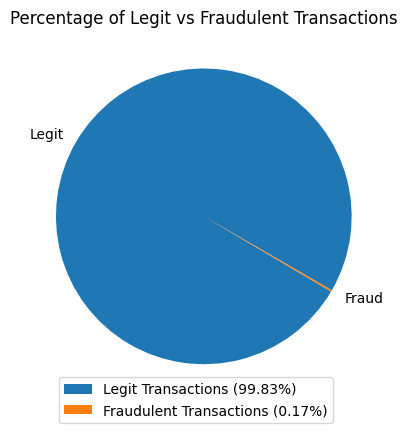

In [7]:
def visualize_legit_vs_fraud(fraud_vs_non_fraud):
    legit, fraud, all = fraud_vs_non_fraud[0], fraud_vs_non_fraud[1], fraud_vs_non_fraud[0] + fraud_vs_non_fraud[1]
    plt.pie(x=fraud_vs_non_fraud, labels=["Legit", "Fraud"], startangle=-30)
    plt.legend([f"Legit Transactions ({round((legit/all)*100, 2)}%)", f"Fraudulent Transactions ({round((fraud/all)*100, 2)}%)"], bbox_to_anchor=(0.5, 0.05), bbox_transform=plt.gcf().transFigure, loc="lower center")
    plt.title("Percentage of Legit vs Fraudulent Transactions")
    plt.show()
visualize_legit_vs_fraud(cd_df["Class"].value_counts().tolist())

We can see from the pie chart above that the ratio between fraudulent and legitimate transactions is very large.

### Visualize the data

Majority of the features in the dataset (V1 - V28) are censored, meaning we do not know what the collumn represents, just its value. There are however two features we do something about. Time which is time in seconds since the first transaction in the dataset, and amount in dollars per transaction. We are now going to take a closer look at these features.

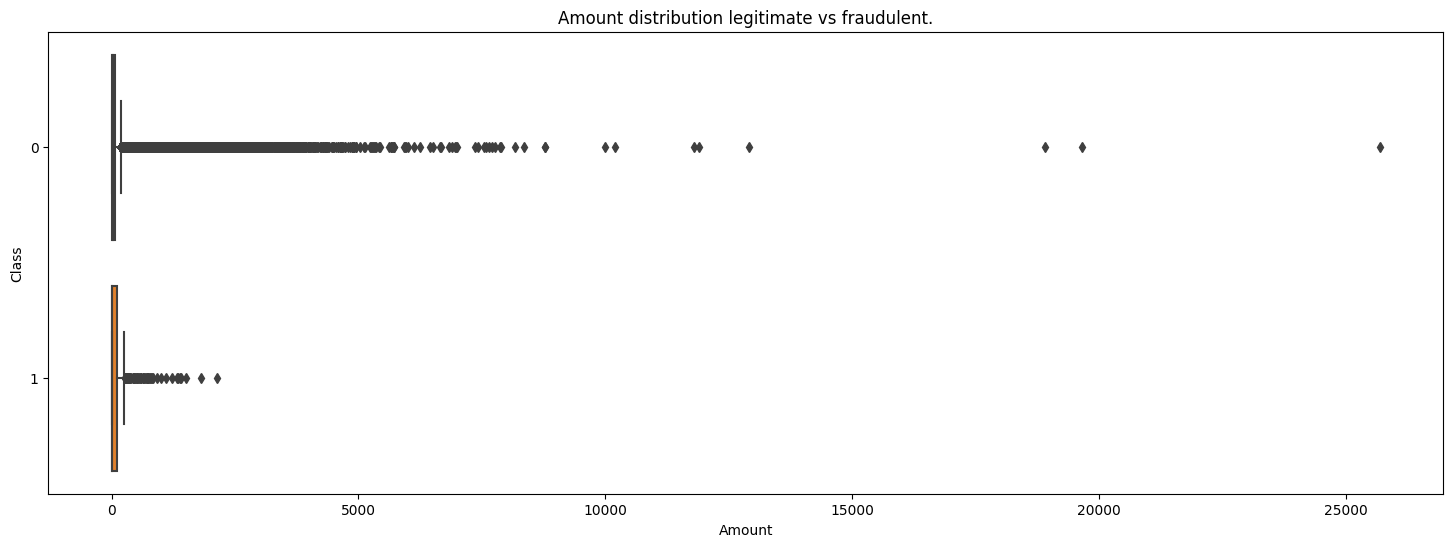

In [8]:
plt.figure(figsize=(18,6))
sns.boxplot(data=cd_df, x="Amount", y="Class", orient="h")
plt.title("Amount distribution legitimate vs fraudulent.")
plt.show()

The boxplot above shows the distribution of the amount feature where class 1 represents fraud and class 0 represents legitimate transactions. As we you can see the legitimate transactions have more and larger outliers. This might occur because bad actors whish to keep a low profile.

Since the outliers are so large in the legitimate transactions we are not able to get a detailed view of the majority of transactions. To counter this we are going to use the same plot but remove the upper 10th percentile of the amount feature.

In [9]:
percentile_90 = cd_df["Amount"].quantile(0.9)
percentile_90

203.38

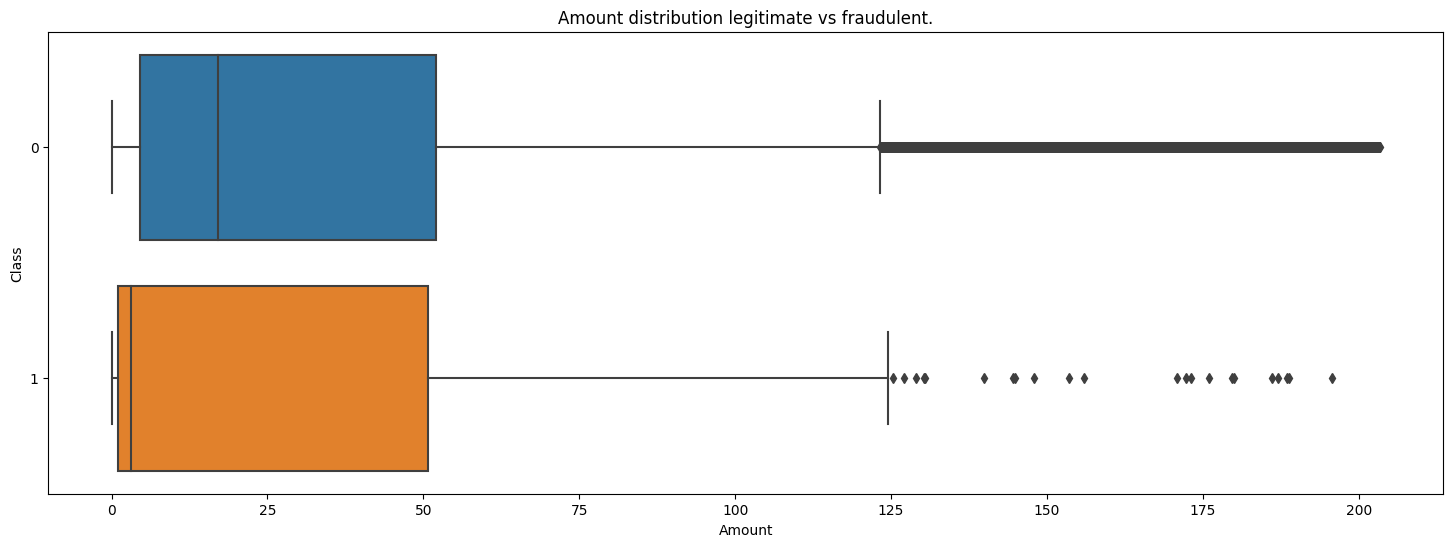

In [10]:
resampeled_amount = cd_df[cd_df["Amount"] < percentile_90]
plt.figure(figsize=(18,6))
sns.boxplot(data=resampeled_amount, x="Amount", y="Class", orient="h")
plt.title("Amount distribution legitimate vs fraudulent.")
plt.show()

After removing the large outliers we get a clearer view of the distribution. The main difference between the fraud and legit case is the median amount. The median amount for the fraud case is about ~ $3 - $4 and the median amount for the legit case is about ~ $15 - $20.

We will now take a closer look at the time feature. As time in this dataset is recorded in seconds we are going to convert it into hours as it is easier to read.

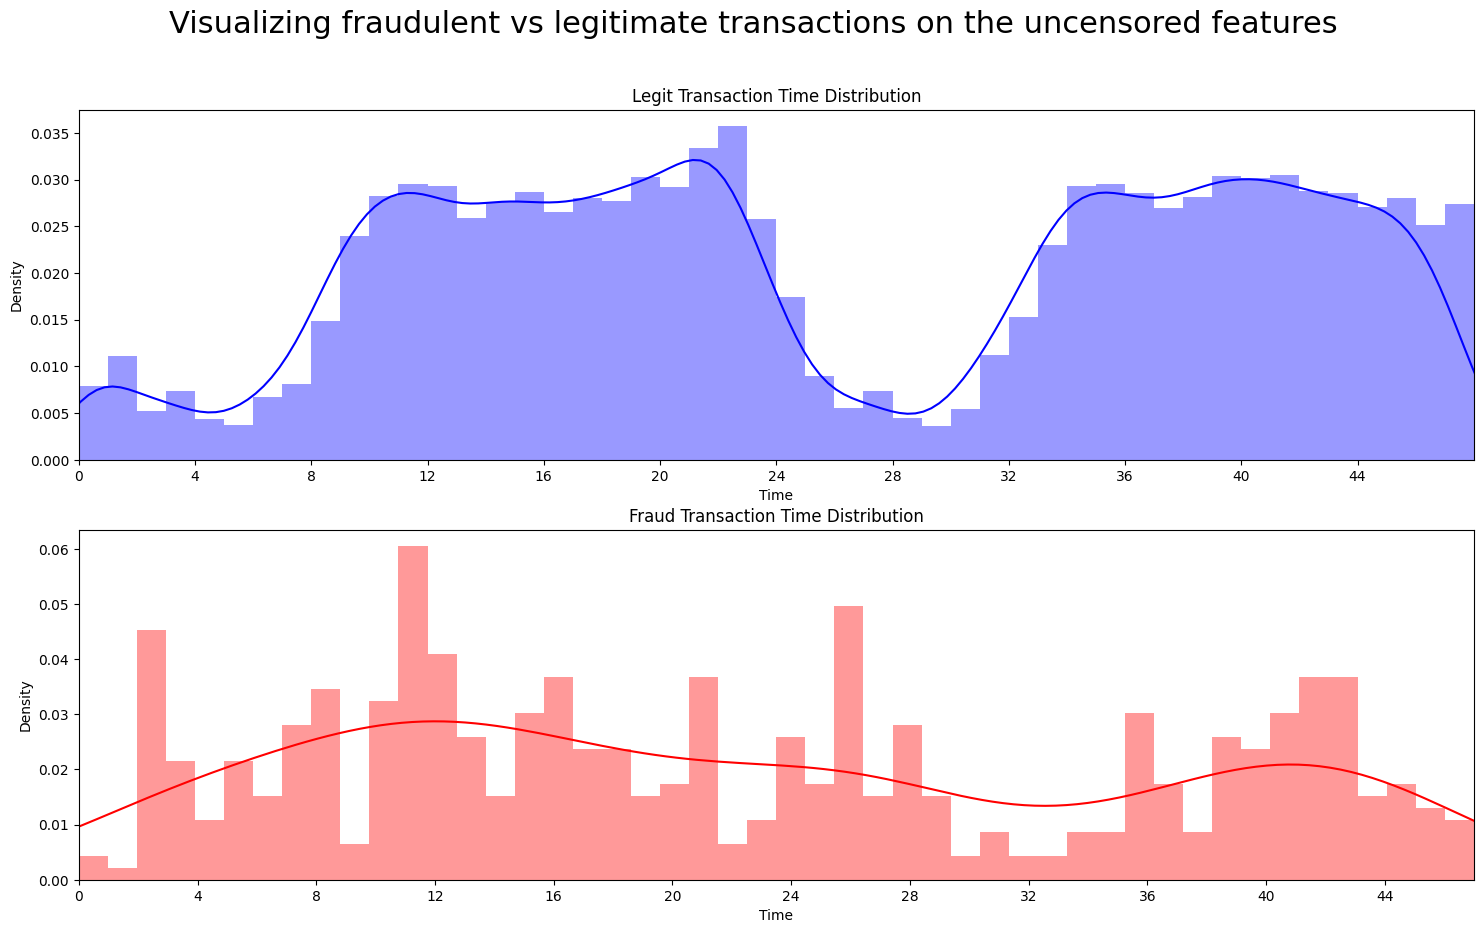

In [11]:
cd_df["Time"] = cd_df["Time"].div(3600).round(0)
legit = cd_df[cd_df["Class"] == 0]
fraud = cd_df[cd_df["Class"] == 1]
test_pd = pd.concat([legit['Amount'], fraud['Amount']], axis=1, keys=['legit', 'fraud'])

fig, ax = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle("Visualizing fraudulent vs legitimate transactions on the uncensored features", fontsize=22)

sns.distplot(legit["Time"], ax=ax[0], color="blue", bins=48)
ax[0].set_title("Legit Transaction Time Distribution")
ax[0].set_xlim([min(legit["Time"]), max(legit["Time"])])
ax[0].set_xticks(np.arange(0,48,4))

sns.distplot(fraud["Time"], ax=ax[1], color="red", bins=48)
ax[1].set_title("Fraud Transaction Time Distribution")
ax[1].set_xlim([min(fraud["Time"]), max(fraud["Time"])])
ax[1].set_xticks(np.arange(0,48,4))
plt.show()

Here we see the distribution of the time feature of both the legit and fraud case. In the legitimate transactions we can se a wave of highs and lows, almost looking like a sine wave. This might indicate the shift from daytime to nigh time, where transactions might be less frequent during night times. The fraudulent transactions however seem to much more stable across time.

## Significant Features
### Plotting the correlation between the different features in the dataset

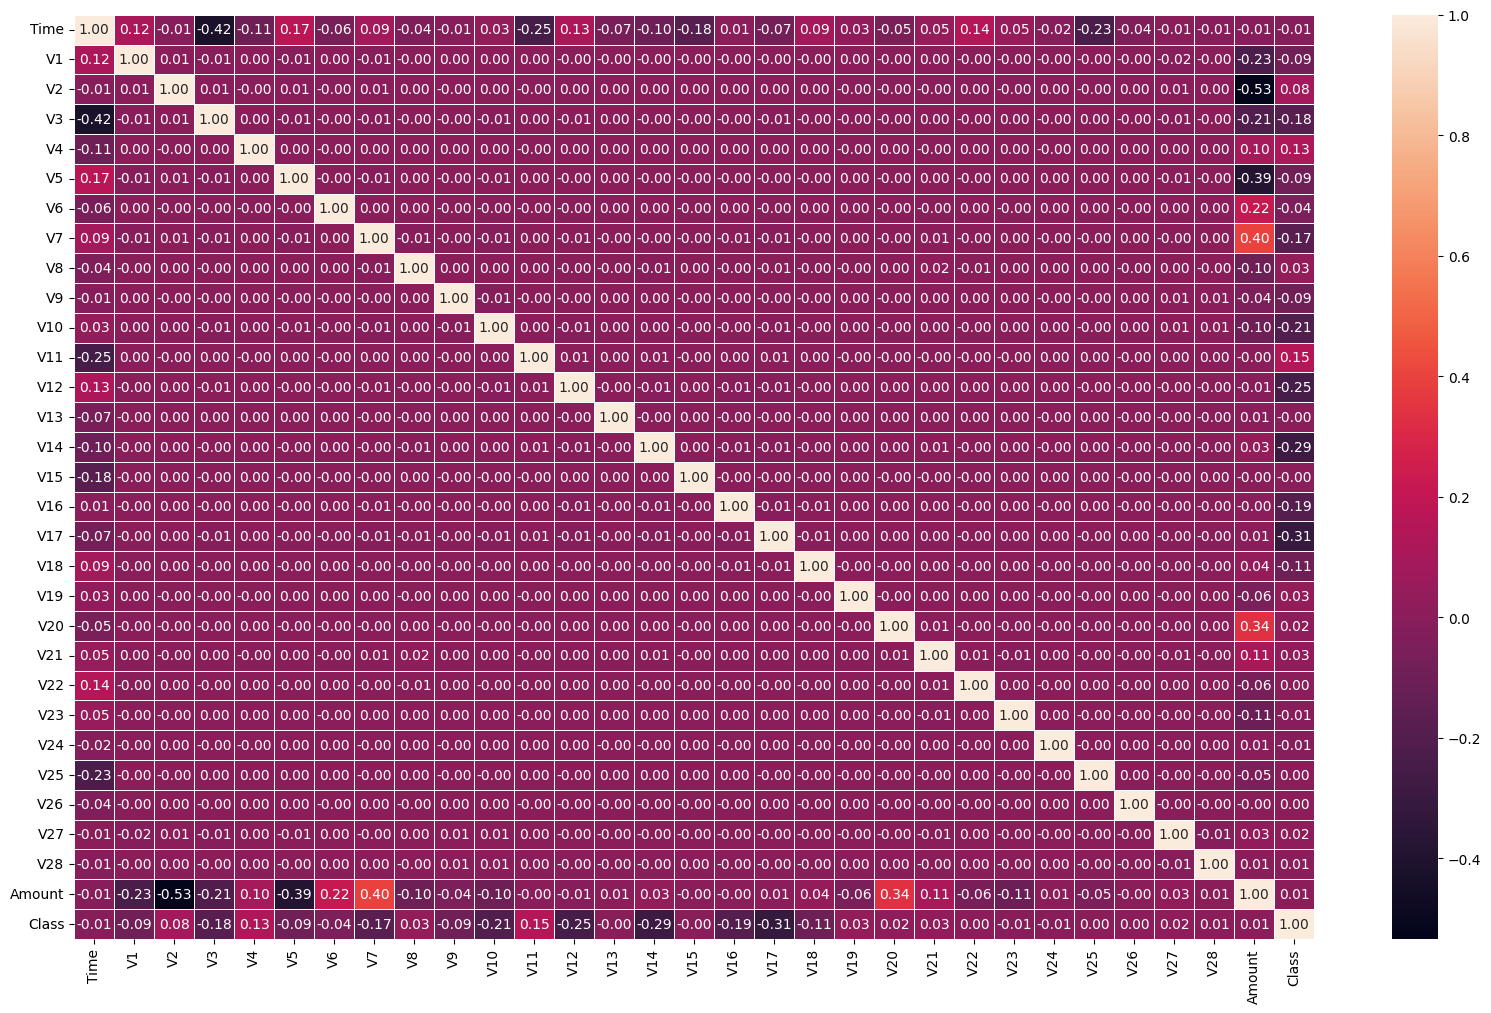

In [12]:
corr = cd_df.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, fmt=".2f", linewidth=0.5)
plt.show()

The heatmap above shows the correlation between each feature in dataset. The diagonal line showing all 1's are the correlations between the same feature and are therefore obviously going to be 1. In this project however we are mainly focused on the correlation between all the features and the label class.

We are therefore going to create a new plot showing only these correlations.

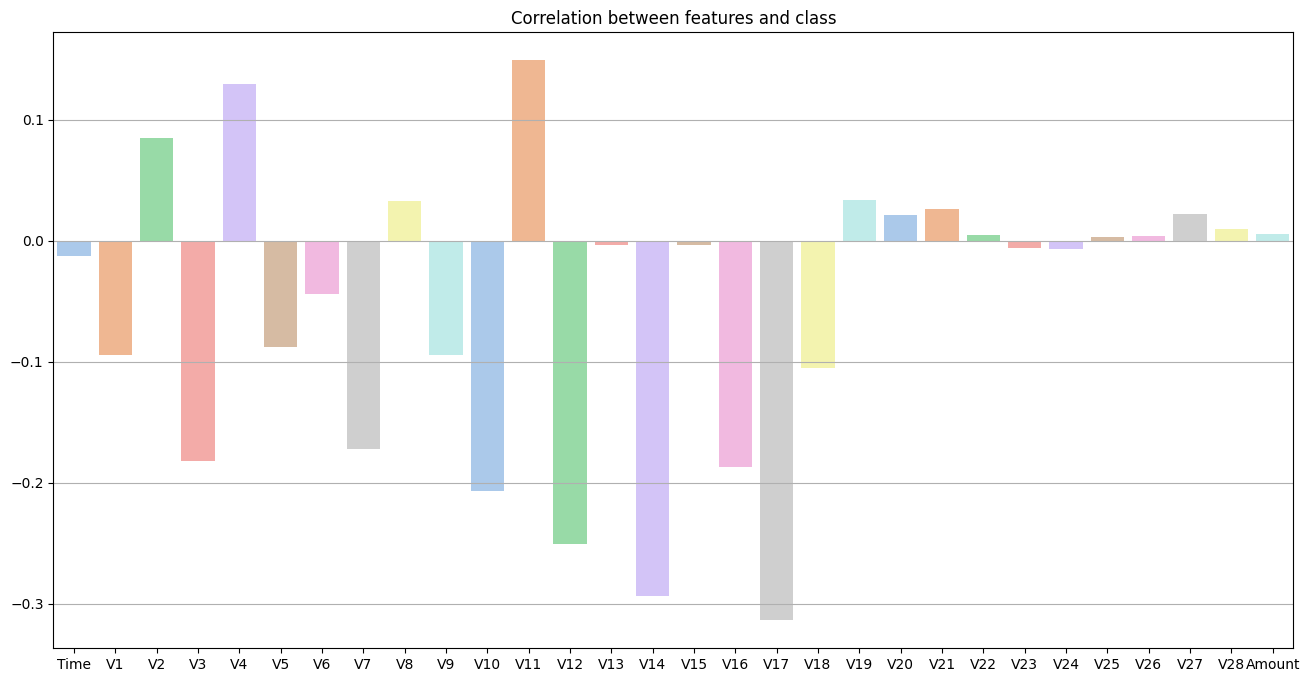

In [13]:
classCorr = corr["Class"]
classCorr = classCorr.iloc[:-1].to_numpy()
cd_df_columns = cd_df.drop('Class', axis=1).columns
plt.figure(figsize=(16, 8))
plt.title("Correlation between features and class")
plt.grid()
sns.barplot(x=cd_df_columns, y=classCorr, palette=sns.color_palette("pastel"))
plt.show()

#### Feature inspection
Now we take a closer look at the most important features based on the bar chart above.

The features inspected are chosen using a minimum absolute value criteria of it's class correlation.

The cutoff chosen is $c_t=0.12$

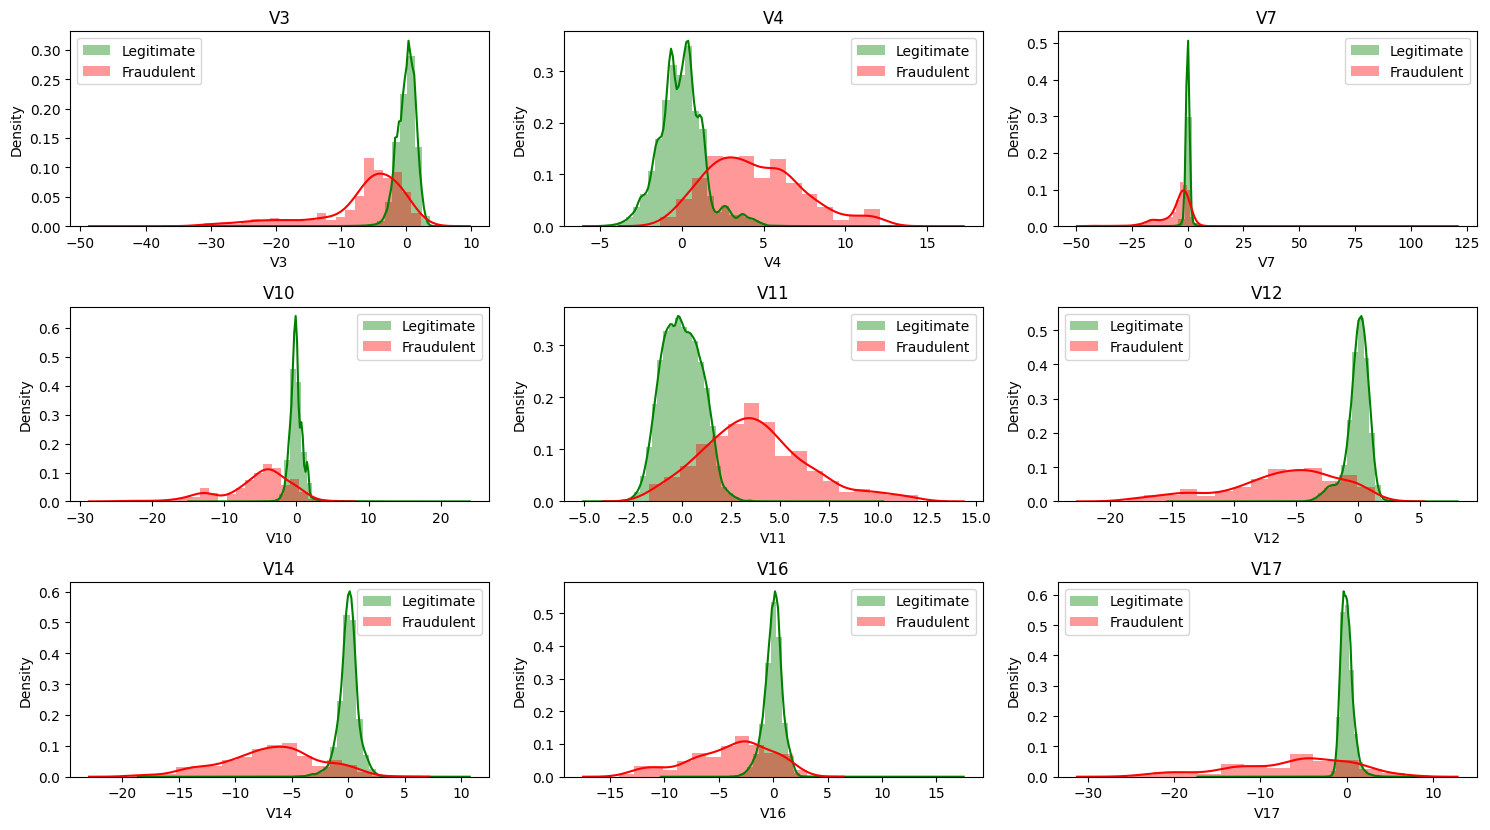

In [14]:
cutoff = 0.12
mostImportantFeatures = [f"V{index}" for index, i  in enumerate(classCorr[:-1]) if np.abs(i) >= cutoff]
if(np.abs(classCorr[-1]) >= cutoff):
    mostImportantFeatures.append("Amount")
plt.figure(figsize=(15,30))
for n, feature in enumerate(mostImportantFeatures):
    plt.subplot(11,3,n+1)
    sns.distplot(cd_df[feature][cd_df.Class == 0], color='green', label="Legitimate")
    sns.distplot(cd_df[feature][cd_df.Class == 1], color='red', label="Fraudulent")
    plt.tight_layout()
    plt.legend()
    plt.title(feature, fontsize=12)

## Building a baseline Model

Before we start building any of our models we will start by proposing a few baseline models.
We will first take a look at the Zero Rate Classifier that proposes that we always guess for the most abundent class.

<a href="https://towardsdatascience.com/calculating-a-baseline-accuracy-for-a-classification-model-a4b342ceb88f#:~:text=Zero%20Rate%20Classifier&text=The%20ZeroR%20(or%20Zero%20Rate,just%20going%20with%20the%20odds.">Source: Zero Rate Classifier</a>

In [15]:
legit_transactions = (cd_df["Class"]==0).sum()
fraud_transactions = (cd_df["Class"]==1).sum()
print(f"fraud transactions vs legit: {legit_transactions}, {fraud_transactions} \n")
print(f"Guessing for the largest class gives us a accuracy of: \
{round(((legit_transactions)/(legit_transactions+fraud_transactions))*100, 2)}% \n ")

fraud transactions vs legit: 283253, 473 

Guessing for the largest class gives us a accuracy of: 99.83% 
 


However this baseline model will only ever predict the negativ class meaning no fraud occured which
in this instance is useless.

Using Weighted Guessing we can guess how many cases of class 1 and 0 appear based on the amount in the dataset.
The guesses will be proportional to how many cases there are of the classes in the dataset.
So we will guess 1, fraud 0.17% of the time and 0, legit 99.83% of the time. Percentages taken from the previous pie chart.

In [16]:
legit_percentage = ((legit_transactions)/(legit_transactions+fraud_transactions))
fraud_precentage = ((fraud_transactions)/(legit_transactions+fraud_transactions))
print(f"Weighted guessing gives us a accuracy of: {round((legit_percentage**2 + fraud_precentage**2)*100, 2)}% \n")

Weighted guessing gives us a accuracy of: 99.67% 



So if you were to guess on fraud vs legit proportional to their occurences you would be right 99.66% of the time.
This is for the unbalanced dataset.

Our baseline performance on the balanced dataset for both of these methods would return 50% accuracy
as there would be a 50/50 split between fraud and legit transactions.

### Naive Bayes model 

We start off be testing the Naive Bayes classifier. This model is simple yet fast and accurate for binary classification problems. It works by taking a sum of all the features probabilites given either class. In this project we will be using the Gaussian version of the Naive Bayes model as we are dealing with continuous values, not discrete.

<a href="https://www.kdnuggets.com/2020/06/naive-bayes-algorithm-everything.html">Source: Naive Bayes</a>

We start by training a Naive Bayes model on our unprocessed data and evaluate the performance of our model.

In [17]:
labels = cd_df["Class"]
features = cd_df.drop("Class", axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=rnd_state)


classifier=GaussianNB()

classifier.fit(x_train , y_train)
train_score = classifier.score(x_train, y_train)
test_score = classifier.score(x_test, y_test)
pred = classifier.predict(x_test)

print(f"training score: {train_score} \n")
print(f"test score: {test_score} \n")
print(f"Overfitting: {train_score-test_score} \n")

training score: 0.9776059564719358 

test score: 0.9776548126740211 

Overfitting: -4.8856202085278966e-05 




#### Confusion matrix plot

A confusion matrix is a description of results. It is a 2-by-2 matrix with true prognosis against predicted prognosis. Whenever a binary classification is performed, a confusion matrix will put a number to its correct and incorrect prediction. Commonly used in all fields that test for something, where the test returns posetiv or negative. 
The correct predictions are True, both posetive and negativ, and false for incorrect predictions. 


Text(0.5, 1.0, 'Naive Bayes Model Confusion Matrix (Unbalanced)')

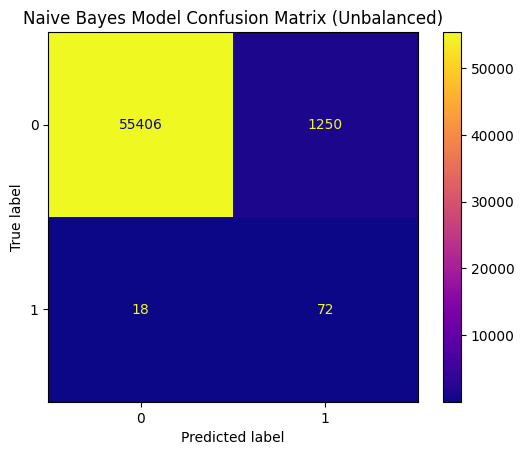

In [18]:
plot_confusion_matrix(classifier, x_test, y_test, cmap='plasma')
plt.title('Naive Bayes Model Confusion Matrix (Unbalanced)', fontsize=12)

Here we can clearly see that the model is not accurate in its predictions regarding fraudulent transactions. This is due to overfitting. Overfitting occurs when the model is not able to generalize a "rule" from the training set and therefore is not able to accurately predict new incomming data. One of the reasons this can happen is when there are not enough data that represents a class, which in this case would be the fraud case.

<a href="https://aws.amazon.com/what-is/overfitting/">Source: Overfitting</a>

#### Classification report

In [19]:
report = classification_report(y_test, pred)
print(f"Classification Report: \n{report}")

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56656
           1       0.05      0.80      0.10        90

    accuracy                           0.98     56746
   macro avg       0.53      0.89      0.55     56746
weighted avg       1.00      0.98      0.99     56746



Here we can see that the models performance when it comes to precision and recall for the positive case is very poor.

Here precision is defined as the ratio $\frac{TP}{TP + FP}$ and recall is defined as $\frac{TP}{TP + FN}$. From the CFM above this would give us: $Precision = \frac{50}{50+365} \approx 0.12$ and $Recall = \frac{50}{50+40} \approx 0.56$. The f1-score is defined as a mean combination between recall and precision. Although the model is very good at predicting negative cases, we are most interested in being able to accurately predict positive cases of fraud in this project.

<a href="https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec">Source: Classification Report</a>

## Preprocessing

We will now process the data and see whether that helps our models to be better able to predict fraudulent transactions.

### Rescaling

We start off by rescaling the amount features to values between -1 and 1.

In [20]:
std_scaler = StandardScaler()
preprocess_df = cd_df.copy()
preprocess_df["New_amount"] = std_scaler.fit_transform(
    preprocess_df["Amount"].values.reshape(-1, 1))

preprocess_df.drop(['Amount', 'Time'], axis=1, inplace=True)

x = preprocess_df.drop("Class", axis=1)
y = preprocess_df["Class"]

### Different upsampling methods

There are many ways to create new data from original data. Since the dataset is so unbalanced, upsampling is definately a good idea, but choosing a upsampling method is not as simple. Therefore since our problem statement is to find out how the unbalanced dataset affects the prediction models, we also need to account for different balancing methods. 

<a href="https://towardsdatascience.com/7-over-sampling-techniques-to-handle-imbalanced-data-ec51c8db349f">Source: Oversampling techniques</a>


In [21]:
def testWithSmote(cd_df_, smote):
    data_noTime_df = cd_df_.drop(['Time'], axis=1)
    x = data_noTime_df.drop("Class", axis=1)
    y = data_noTime_df["Class"]
   
    x_balanced, y_balanced = smote.fit_resample(x, y)

    y_balanced = pd.DataFrame({"Class": y_balanced.values})

    x_train, x_test, y_train, y_test = train_test_split(
        x_balanced, y_balanced, test_size=0.2, random_state=0)
    
    classifier.fit(x_train , y_train)
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    pred = classifier.predict(x_test)
    f1 = f1_score(y_test, pred)
    rec_score = recall_score(y_test, pred)
    report = classification_report(y_test, pred)
    print(report)

    return train_score, test_score, f1, rec_score

#### Synthetic Minority Oversampling Technique (SMOTE)
This method creates new syntethic samples by utilizing a k-nearest neighbor algorithm. It basically creates samples between already existing samples, with some random element to where exactly between each datapoint it ends up being. 

<a href="https://towardsdatascience.com/7-over-sampling-techniques-to-handle-imbalanced-data-ec51c8db349f">Source: Oversampling techniques</a>




In [22]:
result_smote_data = []
smote_standard  = SMOTE(random_state=rnd_state)
smote_standard_train, smote_standard_test, smote_standard_f1, smote_standard_recall = testWithSmote(cd_df, smote_standard)
result_smote_data.append(["smote_standard", smote_standard_train, smote_standard_test, smote_standard_f1, smote_standard_recall])

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     56461
           1       0.97      0.86      0.91     56841

    accuracy                           0.91    113302
   macro avg       0.92      0.91      0.91    113302
weighted avg       0.92      0.91      0.91    113302



In [23]:
kmeansSmote = KMeansSMOTE(k_neighbors=5, cluster_balance_threshold=0.0001, random_state=rnd_state)
kmeansSmote_train, kmeansSmote_test, kmeansSmote_f1, kmeansSmote_recall = testWithSmote(cd_df, kmeansSmote)
result_smote_data.append(["kmeansSmote", kmeansSmote_train, kmeansSmote_test, kmeansSmote_f1, kmeansSmote_recall])

              precision    recall  f1-score   support

           0       0.88      0.98      0.93     56534
           1       0.98      0.87      0.92     56769

    accuracy                           0.92    113303
   macro avg       0.93      0.92      0.92    113303
weighted avg       0.93      0.92      0.92    113303



#### Borderline SMOTE

This method is similar to the previous, but quite simply doesn't use outlier points. It classifies the data into border and noise points, and only uses the border points to create new samples. 

<a href="https://towardsdatascience.com/7-over-sampling-techniques-to-handle-imbalanced-data-ec51c8db349f">Source: Oversampling techniques</a>



In [24]:
borderlineSmote = BorderlineSMOTE(random_state=rnd_state) 
borderlineSmote_train, borderlineSmote_test, borderlineSmote_f1, borderlineSmote_recall = testWithSmote(cd_df, borderlineSmote)
result_smote_data.append(["borderlineSmote", borderlineSmote_train, borderlineSmote_test, borderlineSmote_f1, borderlineSmote_recall])

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     56461
           1       0.97      0.91      0.94     56841

    accuracy                           0.94    113302
   macro avg       0.94      0.94      0.94    113302
weighted avg       0.94      0.94      0.94    113302



#### Borderline-SMOTE SVM

This method again is quite similar to the previous, except that it replaces K-nearest with SVM, to identify missclassified examples on the decision boundary.

<a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">Source: SMOTE for Imbalanced Classification with Python</a>



In [25]:
svmSmote = SVMSMOTE(random_state=rnd_state)
svmSmote_train, svmSmote_test, svmSmote_f1, svmSmote_recall = testWithSmote(cd_df, svmSmote)
result_smote_data.append(["svmSmote", svmSmote_train, svmSmote_test, svmSmote_f1, svmSmote_recall])

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56461
           1       0.97      0.94      0.96     56841

    accuracy                           0.96    113302
   macro avg       0.96      0.96      0.96    113302
weighted avg       0.96      0.96      0.96    113302



#### Adaptive Synthetic Sampling (ADASYN)

This method is a advanced version of SMOTE, which now creates more samples in the minority class where there is a lower density of samples of that class.

<a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">Source: SMOTE for Imbalanced Classification with Python</a>



In [26]:
adasyn = ADASYN(random_state=rnd_state)
adasyn_train, adysan_test, adasyn_f1, adasyn_recall = testWithSmote(cd_df, adasyn)
result_smote_data.append(["adasyn", adasyn_train, adysan_test, adasyn_f1, adasyn_recall])

              precision    recall  f1-score   support

           0       0.75      0.96      0.84     56534
           1       0.94      0.69      0.79     56769

    accuracy                           0.82    113303
   macro avg       0.85      0.82      0.82    113303
weighted avg       0.85      0.82      0.82    113303



In [27]:
smote_pd = pd.DataFrame(result_smote_data, columns=["Smote method", "Train Accuracy", "Test Accuracy", "f1-score", "Recall"])
smote_pd.sort_values(by=["f1-score"], ascending=False).style.background_gradient()

,Smote method,Train Accuracy,Test Accuracy,f1-score,Recall
3,svmSmote,0.956558,0.956108,0.955411,0.937316
2,borderlineSmote,0.943354,0.942243,0.940653,0.912387
1,kmeansSmote,0.923788,0.923303,0.918832,0.866424
0,smote_standard,0.917055,0.914379,0.909364,0.856178
4,adasyn,0.823351,0.821867,0.794213,0.686061


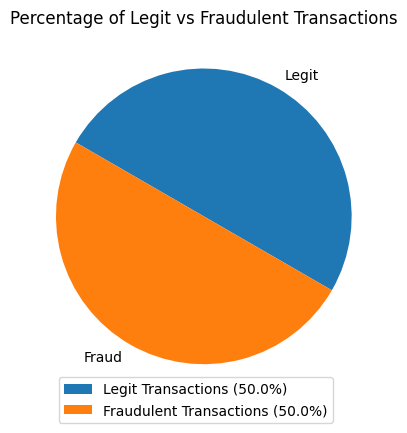

In [28]:
balanced_x, balanced_y = smote_standard.fit_resample(x, y)

balanced_x["Class"] = balanced_y.values
balanced_y = pd.DataFrame({"Class": balanced_y.values})

visualize_legit_vs_fraud(
    balanced_y["Class"].value_counts().tolist())

As we can see after upsampling the fraudulent cases the dataset is now balanced at a 50/50 ratio between fraud and legit transactions.

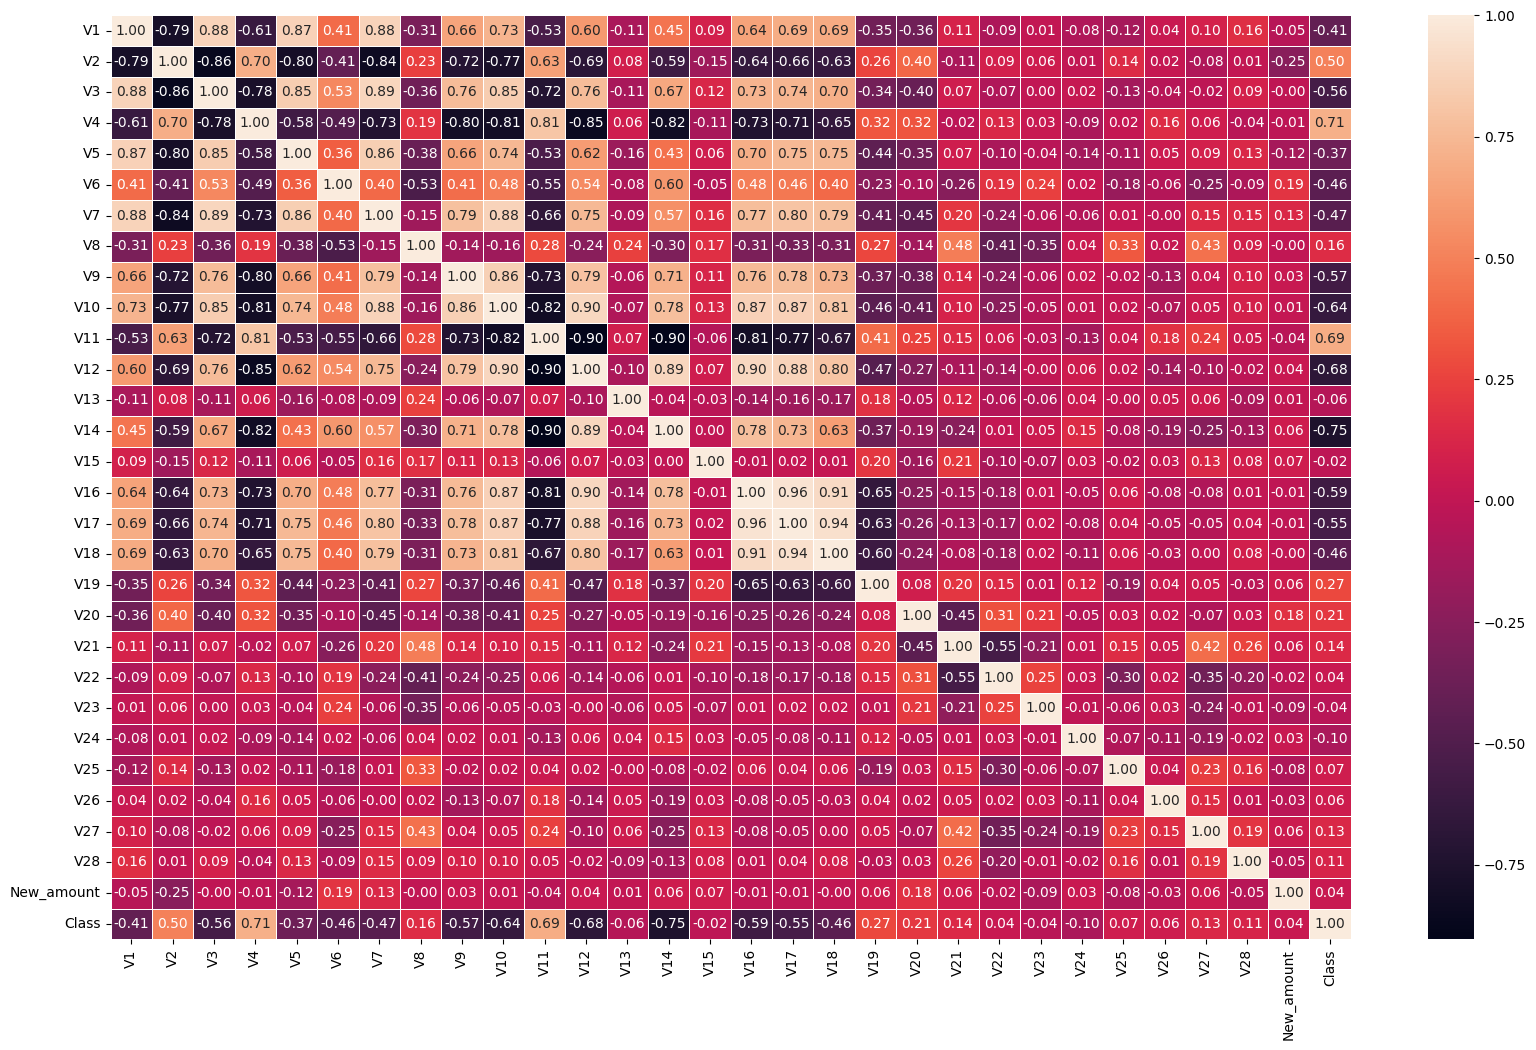

In [29]:
balanced_x, balanced_y = smote_standard.fit_resample(x, y)
balanced_df = balanced_x.join(balanced_y)

balanced_corr = balanced_df.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(balanced_corr, annot=True, fmt=".2f", linewidth=0.5)
plt.show()

The heatmap above displays the new correlation between each feature after using the SMOTE upsampling

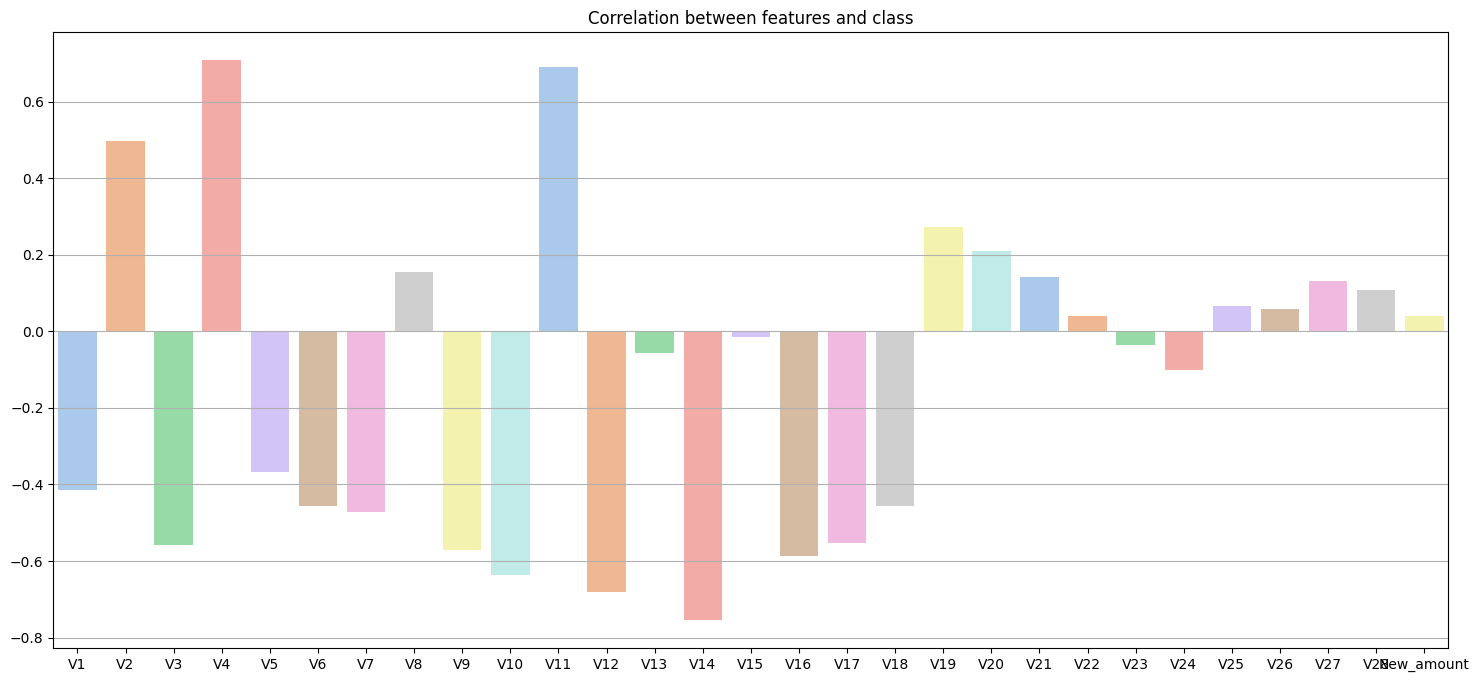

In [30]:
balanced_class_corr = balanced_corr["Class"]
balanced_class_corr = balanced_class_corr.iloc[:-1].to_numpy()
balanced_df.rename(index={'Amount_reshaped':'Amount'}, inplace=True)
cd_df_columns = balanced_df.drop('Class', axis=1).columns
plt.figure(figsize=(18, 8))
plt.title("Correlation between features and class")
plt.grid()
sns.barplot(x=cd_df_columns, y=balanced_class_corr, palette=sns.color_palette("pastel"))
plt.show()

# classCorr = corr_barplot(corr, balanced_df)

Showing the correlation between all the features and Class of the balanced dataset.

In [31]:
x_balanced_train, x_balanced_test, y_balanced_train, y_balanced_test = train_test_split(
    balanced_x, balanced_y, test_size=0.2, random_state=rnd_state)

balanced_NB_classifier=GaussianNB()

balanced_NB_classifier.fit(x_balanced_train , y_balanced_train)
train_balanced_NB_score = balanced_NB_classifier.score(x_balanced_train, y_balanced_train)
test_balanced_NB_score = balanced_NB_classifier.score(x_balanced_test, y_balanced_test)
balanced_NB_pred = balanced_NB_classifier.predict(x_balanced_test)

print(f"training score: {train_balanced_NB_score} \n")
print(f"test score: {test_balanced_NB_score} \n")
print(f"Overfitting: {train_balanced_NB_score-test_balanced_NB_score} \n")

training score: 0.9122117192257791 

test score: 0.9126052496866781 

Overfitting: -0.00039353046089896093 



Text(0.5, 1.0, 'Naive Bayes Model Confusion Matrix (balanced)')

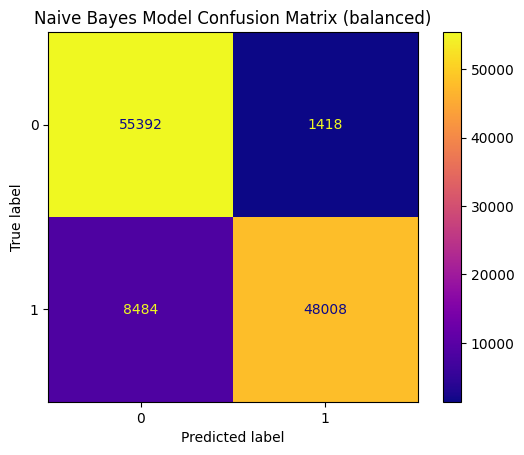

In [36]:
plot_confusion_matrix(balanced_NB_classifier, x_balanced_test, y_balanced_test, cmap='plasma')
plt.title('Naive Bayes Model Confusion Matrix (balanced)', fontsize=12)

In [33]:
balanced_NB_report = classification_report(y_balanced_test, balanced_NB_pred)
nb_f1 = f1_score(y_balanced_test, balanced_NB_pred)
nb_recall = recall_score(y_balanced_test, balanced_NB_pred)
print(f"Classification Report: \n{balanced_NB_report}")
conclusion_matrix = []
conclusion_matrix.append(["Naive Bayes", train_balanced_NB_score, test_balanced_NB_score, nb_f1, nb_recall])

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     56810
           1       0.97      0.85      0.91     56492

    accuracy                           0.91    113302
   macro avg       0.92      0.91      0.91    113302
weighted avg       0.92      0.91      0.91    113302



Here we can already see a dramatic increase in both precision, recall and f1-score for the positive case of fraud (0.91 f1-score compared to 0.2 on the unbalanced set). 

## K Nearest Neighbor
The KNN model is described as a more simple and lazy model for machine learning. It workes best for binary classification and smaller datasets.

The basic explanation for this model, is to group datapoints into differnet groups based on their attributes. Datapoints with similar attribute values are classified togheter, calculated by how near a datapoint is to its neighbors. The amount of neighbours to check is the K-factor, and there are different approaches to finding an optimal k-factor. 

Our dataset is binary, but quite large for this model.


<a href="https://scikit-learn.org/stable/modules/neighbors.html#classification">Source: SKLearn KNN</a>

In [34]:
balanced_x, balanced_y = smote_standard.fit_resample(x, y)

balanced_y = pd.DataFrame({"Class": balanced_y.values})

balanced_df = balanced_x.join(balanced_y)


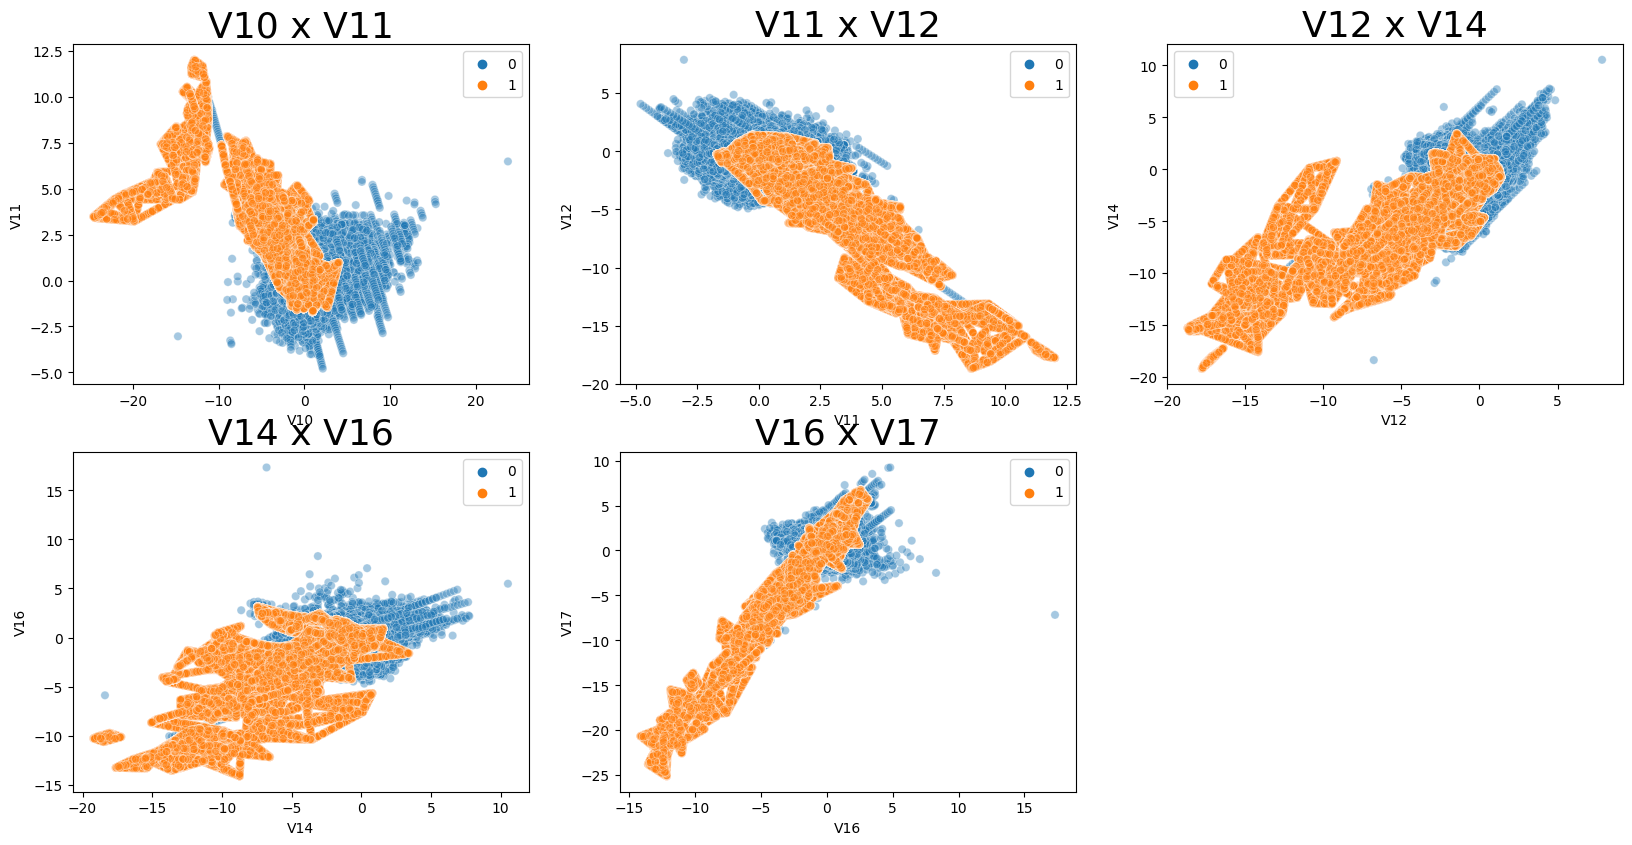

In [38]:
importantFeatures = mostImportantFeatures[3:]
plt.figure(figsize=(20,15))
for n in range(len(importantFeatures)-1):
    plt.subplot(3,3,n+1)
    sns.scatterplot(data=balanced_df, x=importantFeatures[n], y=importantFeatures[n+1], alpha=0.4, hue="Class")
    plt.legend()
    plt.title(f"{importantFeatures[n]} x {importantFeatures[n+1]}", fontsize=26)
plt.show()

The scatterplots for the balanced data show some distinctions between frauds and legit transactions, but also a lot of overlap. 

This can prove to be a difficult aspect for the KNN model, given that the two groups are not so clearly defined.

### Reducing the dataset

KNN generally works well with small datasets, but its performance decreases exponentially with the amount of input features. In our dataset we utilize 29 features for determining the following class of said features. This in turn makes the KNN very slow compared to other models.

The dataset we are using could be too large for this somewhat simple algorithm. Therefore we select a smaller subset:
Using .iloc to select the subset.

<a href="https://www.i2tutorials.com/why-cannot-we-use-knn-for-large-datasets/">Source: KNN-Problematic</a>

In [39]:
x_train_short, y_train_short, x_test_short, y_test_short = x_balanced_train.iloc[:1000], y_balanced_train.iloc[:1000], x_balanced_test.iloc[:1000], y_balanced_test.iloc[:1000]

### K-Factors
 We tried different k-factors, and plotted their respective accuracy.

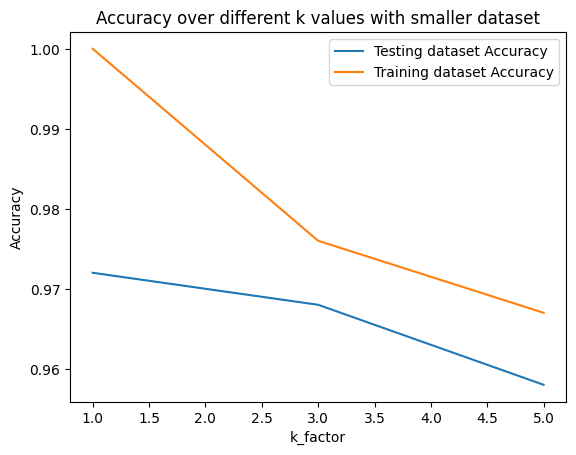

In [40]:
k_factor = np.arange(1, 7, 2)
train_accuracy = np.empty(len(k_factor))
test_accuracy = np.empty(len(k_factor))

for i, k in enumerate(k_factor):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_short, y_train_short)
    train_accuracy[i] = knn.score(x_train_short, y_train_short)
    test_accuracy[i] = knn.score(x_test_short, y_test_short)
  
plt.plot(k_factor, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(k_factor, train_accuracy, label = 'Training dataset Accuracy')
  
plt.legend()
plt.xlabel('k_factor')
plt.ylabel('Accuracy')
plt.title('Accuracy over different k values with smaller dataset')
plt.show()

The model gives the best accuracy with a k-factor of 1, so that is the value that will be used from here on out.

#### Performance

Text(0.5, 1.0, 'KNN-short Model Confusion Matrix ')

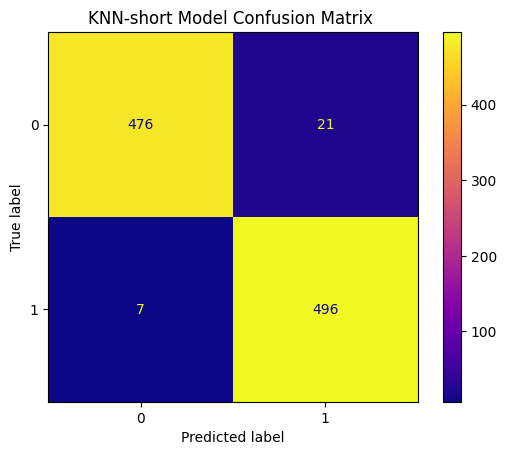

In [41]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(x_train_short , y_train_short)
train_score = knn.score(x_train_short, y_train_short)
test_score = knn.score(x_test_short, y_test_short)
knn_pred = knn.predict(x_test_short)

plot_confusion_matrix(knn, x_test_short, y_test_short, cmap='plasma')
plt.title('KNN-short Model Confusion Matrix ', fontsize=12)

#### Classification Report

In [42]:
knn_report = classification_report(y_test_short, knn_pred)
print(f"Classification Report for KNN model: \n{knn_report}")
knn_f1_score = f1_score(y_test_short, knn_pred)
knn_recall_score = recall_score(y_test_short, knn_pred)
conclusion_matrix.append(["K nearest neighbour", train_score, test_score, knn_f1_score, knn_recall_score])

Classification Report for KNN model: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       497
           1       0.96      0.99      0.97       503

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



### KNN model on original data
If could be the case that the balanced dataset lack clear differences, so we will try with the original data.

#### Scatterplot for original data
Using the scatterplot once again, to see if there is any clear differentses.

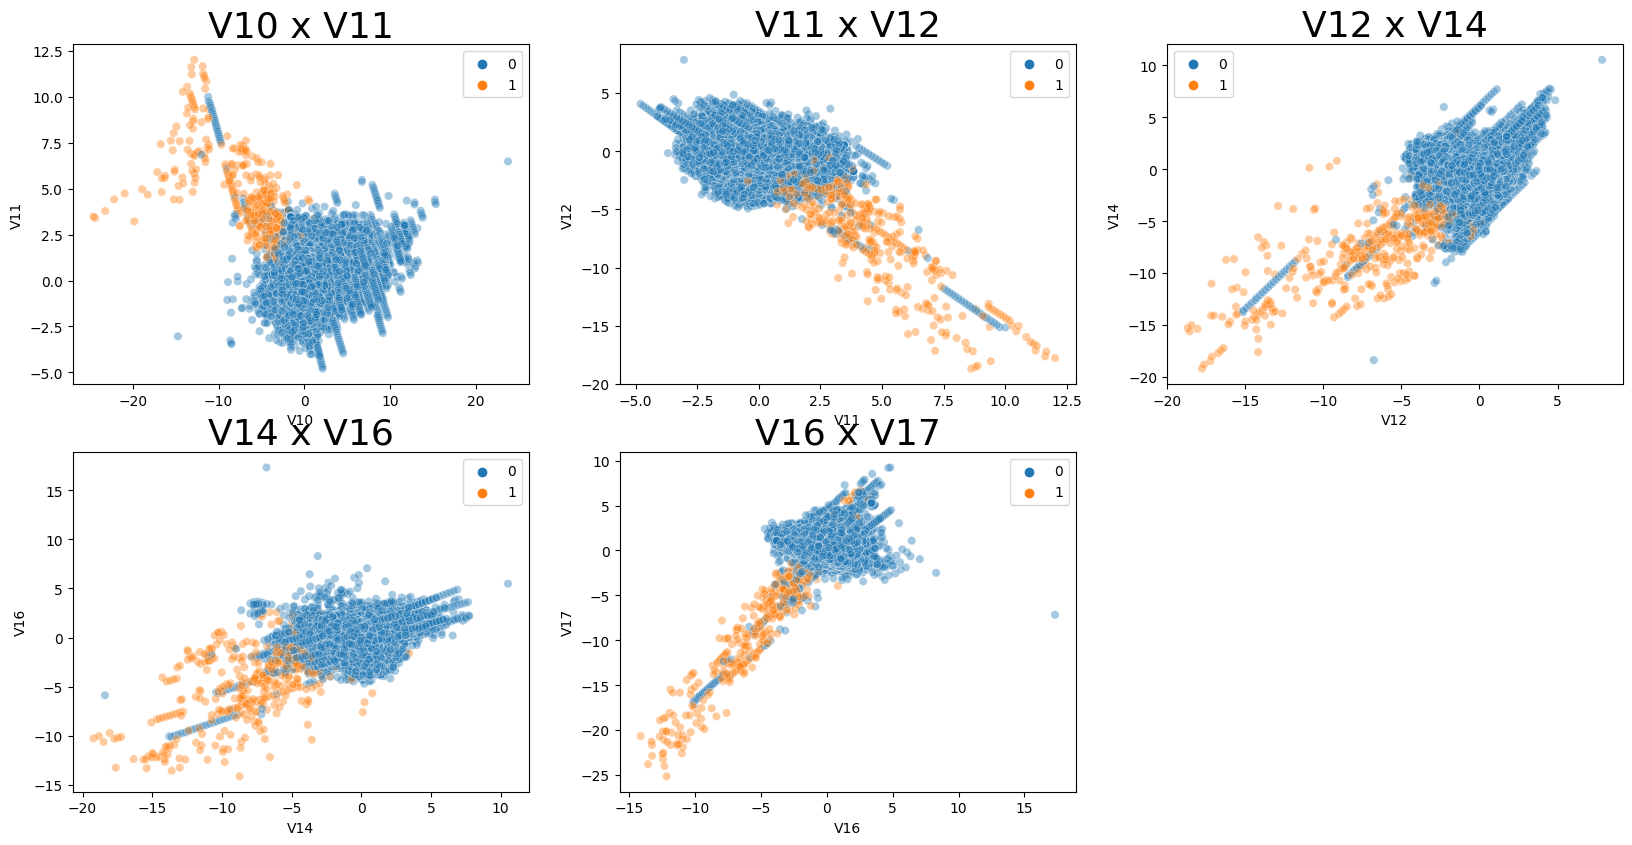

In [43]:
plt.figure(figsize=(20,15))
importantFeatures = mostImportantFeatures[3:]
for n in range(len(importantFeatures)-1):
    plt.subplot(3,3,n+1)
    sns.scatterplot(data=cd_df, x=importantFeatures[n], y=importantFeatures[n+1], alpha=0.4, hue="Class")
    plt.legend()
    plt.title(f"{importantFeatures[n]} x {importantFeatures[n+1]}", fontsize=26)
plt.show()

The most distinct features show clear grouping for the legit class, but the fraud class is more spread out. This works in favour of the KNN model.

### Performance

Text(0.5, 1.0, 'KNN Model Confusion Matrix for Original Data ')

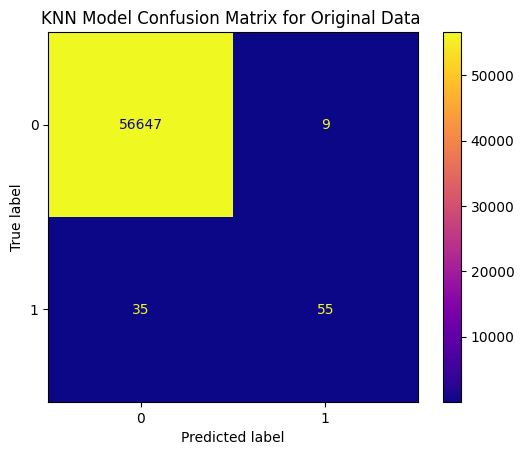

In [44]:
labels = cd_df["Class"]
features = cd_df.drop("Class", axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=rnd_state)

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(x_train , y_train)
train_score = knn.score(x_train, y_train)
test_score = knn.score(x_test, y_test)
knn_pred = knn.predict(x_test)

plot_confusion_matrix(knn, x_test, y_test, cmap='plasma')
plt.title('KNN Model Confusion Matrix for Original Data ', fontsize=12)

In [45]:
knn_report = classification_report(y_test, knn_pred)
print(f"Classification Report for KNN model: \n{knn_report}")

Classification Report for KNN model: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.86      0.61      0.71        90

    accuracy                           1.00     56746
   macro avg       0.93      0.81      0.86     56746
weighted avg       1.00      1.00      1.00     56746



#### KNN Conclusion

The small balanced dataset performed well, probabaly because there were some many datapoints for each class.

The original data performed worse, even though the scatterplot showed a more clear difference in grouping. This is likely because the imbalance between the classes gave a bias in favour of legit transactions. There were way more false negatives than false positives.

This classification model does not work well with such an imbalanced dataset.

## Neural Network Model

### Get clean start for all data

In [46]:
cd_df = pd.read_csv("creditcard.csv")

In [47]:
rnd_state = 69

std_scaler = StandardScaler()
preprocess_df = cd_df.copy()
preprocess_df["New_amount"] = std_scaler.fit_transform(
    preprocess_df["Amount"].values.reshape(-1, 1))

preprocess_df["New_time"] = std_scaler.fit_transform(
    preprocess_df["Time"].values.reshape(-1, 1))

preprocess_df.drop(['Amount', 'Time'], axis=1, inplace=True)

data_noTime_df = preprocess_df

### Use borderline SMOTE SVM to upsample

In [48]:
x = data_noTime_df.drop("Class", axis=1)
y = data_noTime_df["Class"]
svmSmote = SVMSMOTE(random_state=rnd_state)
x_balanced, y_balanced = svmSmote.fit_resample(x, y)

### Split into training and test data

In [49]:
y_balanced = pd.DataFrame({"Class": y_balanced.values})

x_train, x_test, y_train, y_test = train_test_split(
    x_balanced, y_balanced, test_size=0.2, random_state=0)

### Train a neural network
This neural network has 1 input layer, 3 hidden layers & 1 output layer. The layers is of the following sizes: 30x60x30x10x1. The number of neurons and hidden layers is choosen experimentally with different epoch parameters, below is the result.
##### EPOCHS = 5
        29, 16, 1 -> 0.9991, 0.9991
        29, 1 -> 0.9988, 0.9989
        58, 29, 1 -> 0.9993 , 0.9994
        116, 58, 29, 1 -> 0.9994 , 0.9995
        232, 116, 58, 29, 1 -> 0.9994 , 0.9996

In [56]:
nn_model = keras.Sequential([
    keras.Input(shape=(30,)),
    layers.Dense(60, activation="relu"),
    layers.Dense(30, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

nn_model.summary()

nn_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
nn_history = nn_model.fit(x_train, y_train, validation_split=0.1, epochs=5)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 60)                1860      
                                                                 
 dense_5 (Dense)             (None, 30)                1830      
                                                                 
 dense_6 (Dense)             (None, 10)                310       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,011
Trainable params: 4,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
12795/12795 [==============================] - 32s 2ms/step - loss: 0.0118 - accuracy: 0.9975 - val_loss: 0.0050 - val_accuracy: 0.9994
Epoch 2/5
12795/12795 [===============

3554/3554 [==============================] - 5s 1ms/step
pred: [[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [1]], test:         Class
484657      1
409771      1
419226      1
89221       0
365095      1
...       ...
518178      1
116382      0
183607      0
21832       0
556418      1

[113726 rows x 1 columns]


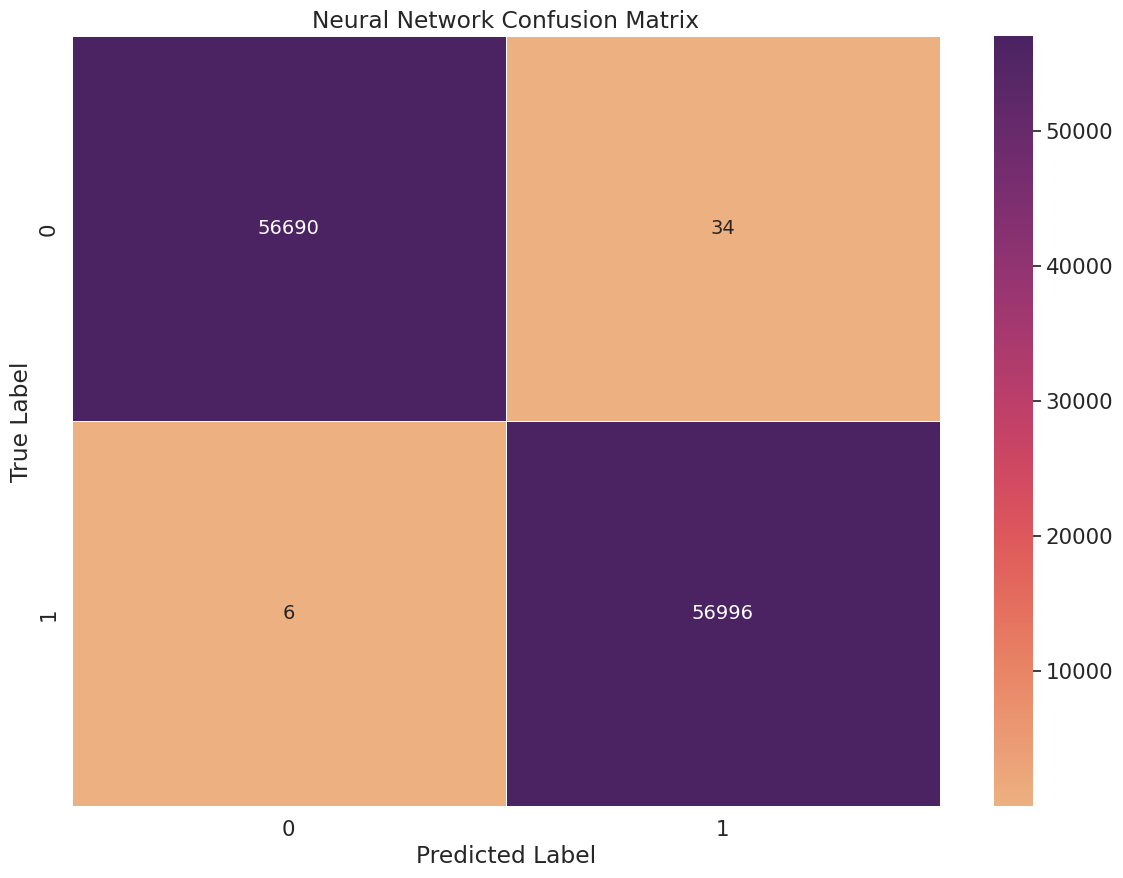

In [57]:
pred = nn_model.predict(x_test)
binary_pred = np.where(pred > 0.5, 1, 0)
print(f"pred: {binary_pred}, test: {y_test}")
result = confusion_matrix(y_test, binary_pred)
result = pd.DataFrame(result, range(2), range(2))
numpy_result = result.to_numpy()
recall = numpy_result[1,1]/(numpy_result[1,0]+numpy_result[1,1])

plt.figure(figsize=(14, 10))
sns.set(font_scale=1.4)
ax = sns.heatmap(result, annot=True, linewidth=0.5, fmt='g',
                 annot_kws={"size": 14}, cmap="flare")
ax.set(xlabel="Predicted Label", ylabel="True Label")
plt.title("Neural Network Confusion Matrix")
plt.show()

In [58]:
nn_f1_score = f1_score(y_test, np.where(nn_model.predict(x_test) > 0.5, 1, 0))
nn_recall_score = recall_score(y_test, np.where(nn_model.predict(x_test) > 0.5, 1, 0))

test_result = nn_model.evaluate(x_test, y_test)
conclusion_matrix.append(["Neural network", nn_history.history["accuracy"][0], test_result[1], nn_f1_score, nn_recall_score])

3554/3554 [==============================] - 6s 2ms/step - loss: 0.0023 - accuracy: 0.9996


8901/8901 [==============================] - 11s 1ms/step
pred: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]], test: 0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64
        0    1
0  284164  151
1      47  445
Recall = 0.9044715447154471


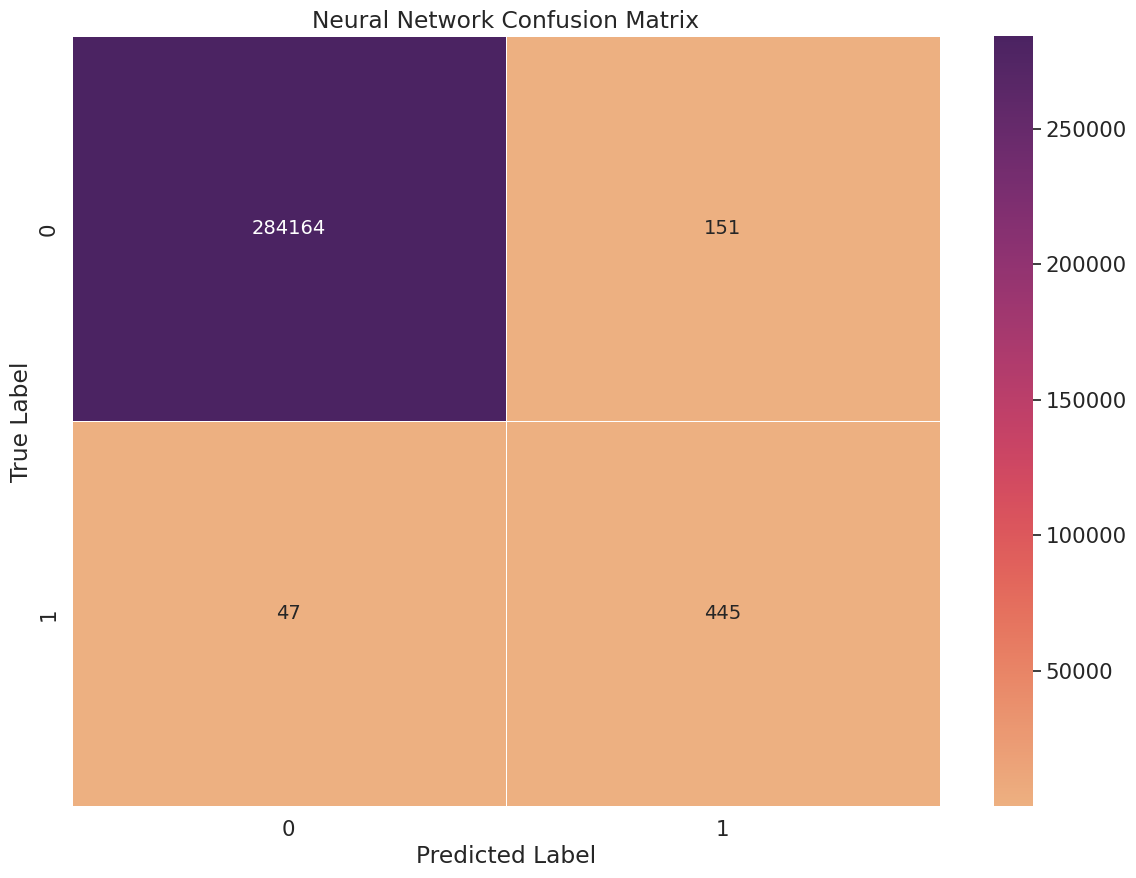

In [59]:
pred = nn_model.predict(data_noTime_df.drop(['Class'],axis=1))
binary_pred = np.where(pred > 0.5, 1, 0)
print(f"pred: {binary_pred}, test: {data_noTime_df['Class']}")
result = confusion_matrix(data_noTime_df['Class'], binary_pred)
result = pd.DataFrame(result, range(2),range(2))
print(result)
numpy_result = result.to_numpy()
recall = numpy_result[1,1]/(numpy_result[1,0]+numpy_result[1,1])
print(f"Recall = {recall}")

plt.figure(figsize=(14, 10))
sns.set(font_scale=1.4)
ax = sns.heatmap(result, annot=True, linewidth=0.5, fmt='g', annot_kws={"size": 14}, cmap="flare")
ax.set(xlabel="Predicted Label", ylabel="True Label")
plt.title("Neural Network Confusion Matrix")
plt.show()

In [60]:
nn_report = classification_report(data_noTime_df['Class'], binary_pred) # original data
print(nn_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.75      0.90      0.82       492

    accuracy                           1.00    284807
   macro avg       0.87      0.95      0.91    284807
weighted avg       1.00      1.00      1.00    284807



## Conclusion
Looking back at the difference between the neural network's f1-score using upsampled data and the original data for training, which then both tried to predict all of the original set, it can be observed that the more balanced albeit artificial dataset is better for training the classifier, even when only performing predictions the original dataset. 

This is a direct answer to our research question. This result fits the expected outcome of the models based on our dataset's content.

In [61]:
conclusion_report = pd.DataFrame(conclusion_matrix, columns=["Model", "Train Score", "Test Score", "f1-score", "Recall Score"])
conclusion_report.sort_values(by=["f1-score"], ascending=False).style.background_gradient()

,Model,Train Score,Test Score,f1-score,Recall Score
3,Neural network,0.997521,0.999648,0.999649,0.999895
2,Neural network,0.998017,0.999288,0.999290,0.999895
1,K nearest neighbour,1.000000,0.972000,0.972549,0.986083
0,Naive Bayes,0.912212,0.912605,0.906513,0.849819


From the table above we can see that the neural network outperforms the other classifiers on every metric.